In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# need this cell to import the help functions:

import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [3]:
# import help functions:

from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [4]:
data = CGMData()

In [68]:
# participant_numbers = data.shape()
participant_numbers = 13

In [69]:
# Finding 5/95th percentile idea from Dan Visscher
high_glu = []
low_glu = []

# Find 5th/95th percentile for glucose range for each patient
for i in range(1,participant_numbers+1):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))


In [70]:
print(high_glu)
print(low_glu)

[137.0, 167.0, 140.0, 145.0, 129.0, 188.0, 128.0, 143.8499999999999, 177.0, 178.0, 166.0, 164.6500000000001, 168.0]
[85.0, 99.0, 85.0, 85.0, 83.0, 93.0, 70.0, 83.0, 97.2, 81.0, 87.0, 99.0, 97.85000000000001]


In [71]:
df = pd.DataFrame()

for pn in range(1,participant_numbers+1):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df_sub = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df_sub)])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 6
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        263 non-null    float64
 1   total_carb     263 non-null    float64
 2   dietary_fiber  263 non-null    float64
 3   sugar          263 non-null    float64
 4   protein        263 non-null    float64
 5   total_fat      263 non-null    float64
 6   gi             263 non-null    float64
 7   gl             263 non-null    float64
 8   recent_meals   263 non-null    float64
 9   participant    263 non-null    int64  
 10  max_glucose    232 non-null    float64
 11  start_glucose  232 non-null    float64
 12  diff_glucose   232 non-null    float64
 13  mean_temp      196 non-null    float64
 14  mean_hr        197 non-null    float64
 15  mean_acc       196 non-null    float64
 16  mean_eda       196 non-null    float64
 17  high_glucose   263 non-null    bool   
dtypes: bool(1), float

In [72]:
# Number of food intake entries for which there is no corresponding glucose data
df['max_glucose'].isna().sum()

31

In [73]:
# Drop these data points
df = df.dropna(subset=['max_glucose'])

In [74]:
# Check
df['max_glucose'].isna().sum()

0

In [108]:
df

,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl,recent_meals,participant,max_glucose,start_glucose,diff_glucose,mean_temp,mean_hr,mean_acc,mean_eda,high_glucose
0,456.0,85.0,1.7,83.0,16.0,3.3,33.0,28.050,1.0,1,143.0,59.0,84.0,33.605343,76.982429,0.924898,0.478566,True
1,488.0,2.5,1.2,0.8,63.4,23.1,28.0,0.700,1.0,1,106.0,104.0,2.0,34.328719,68.960515,0.661794,2.321904,False
2,230.0,35.0,0.0,18.0,13.0,0.0,56.5,24.620,1.0,1,122.0,92.0,30.0,33.882256,77.987660,0.791241,0.568190,False
3,280.0,30.0,0.0,22.0,4.0,0.0,62.0,18.600,1.0,1,110.0,89.0,21.0,31.511428,87.463506,0.964078,0.483317,False
4,358.0,14.4,0.0,8.7,13.9,0.0,28.0,4.032,1.0,1,124.0,105.0,19.0,30.470737,75.821212,0.461761,0.209723,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,230.0,1.8,0.0,0.3,12.9,18.2,85.0,1.530,1.0,12,117.0,117.0,0.0,NaN,NaN,NaN,NaN,False
2,280.0,56.5,1.0,24.0,8.0,2.5,56.5,45.460,1.0,12,188.0,103.0,85.0,33.643691,63.804413,0.431399,0.246659,True
3,304.0,1.3,0.0,0.4,25.0,21.5,28.0,0.364,1.0,12,102.0,102.0,0.0,31.711159,79.075091,0.988530,1.312554,False
4,2.4,3.3,0.0,0.0,0.3,0.1,28.0,0.924,1.0,12,123.0,119.0,4.0,29.560236,83.110328,1.055531,0.236031,False


In [109]:
df = df[df['total_carb'] <= 400]

In [111]:
# Define variables to fit for Logistic Regression

X = df.total_carb.values
y = df.high_glucose.values

In [112]:
# Split testing and training data

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

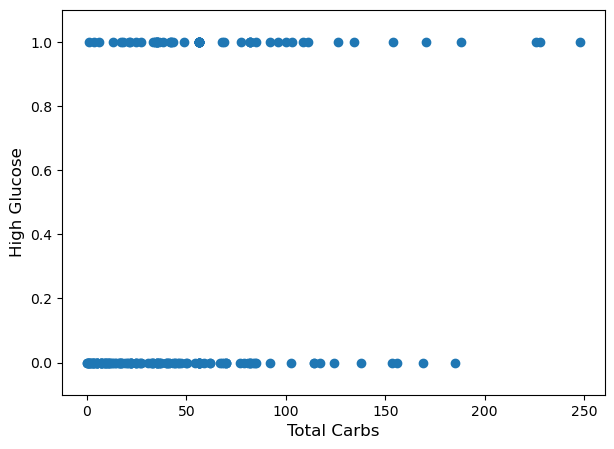

In [113]:
# Plot the training data

plt.figure(figsize = (7,5))

plt.scatter(X_train,y_train)
plt.ylim((-.1,1.1))
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("High Glucose",fontsize = 12)

plt.show()

In [114]:
# Instantiate the logistic regression
log_reg = LogisticRegression(penalty=None)

# Fit the model
log_reg.fit(X_train.reshape(-1,1),
            y_train)

LogisticRegression(penalty=None)

In [115]:
# Make predictions
log_reg.predict(X_train.reshape(-1,1))

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False,

In [116]:
# Quantify the prediction probabilities
log_reg.predict_proba(X_train.reshape(-1,1))

array([[0.56195865, 0.43804135],
       [0.65575018, 0.34424982],
       [0.33282454, 0.66717546],
       [0.71115677, 0.28884323],
       [0.71962839, 0.28037161],
       [0.74831429, 0.25168571],
       [0.79146114, 0.20853886],
       [0.74066326, 0.25933674],
       [0.6123417 , 0.3876583 ],
       [0.78239224, 0.21760776],
       [0.80638426, 0.19361574],
       [0.80660072, 0.19339928],
       [0.77691201, 0.22308799],
       [0.76466188, 0.23533812],
       [0.71682141, 0.28317859],
       [0.76961714, 0.23038286],
       [0.69376666, 0.30623334],
       [0.65575018, 0.34424982],
       [0.65575018, 0.34424982],
       [0.73231923, 0.26768077],
       [0.79146114, 0.20853886],
       [0.71962839, 0.28037161],
       [0.80377238, 0.19622762],
       [0.75453182, 0.24546818],
       [0.75887274, 0.24112726],
       [0.80069164, 0.19930836],
       [0.78497864, 0.21502136],
       [0.65575018, 0.34424982],
       [0.57217367, 0.42782633],
       [0.65575018, 0.34424982],
       [0.

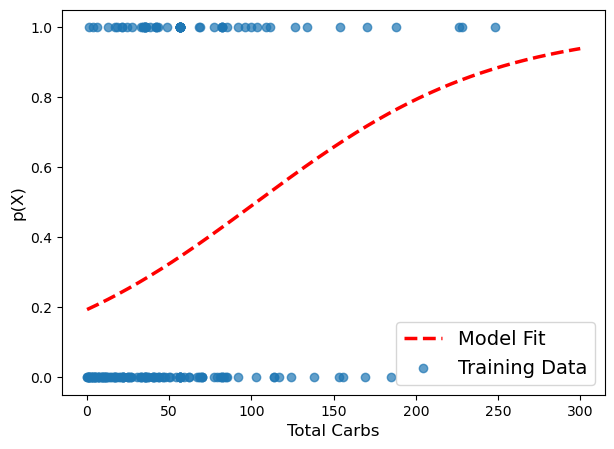

In [117]:
# Plot the training data with the logistic regression

plt.figure(figsize = (7,5))

plt.plot(np.linspace(0,300,1000),
            log_reg.predict_proba(np.linspace(0,300,1000).reshape(-1,1))[:,1],
            'r--',linewidth=2.5,label = "Model Fit")
plt.scatter(X_train,y_train,label = 'Training Data',alpha=.7)
plt.legend(fontsize = 14,loc = 4)
plt.xlabel("Total Carbs",fontsize = 12)
plt.ylabel("p(X)",fontsize=12) 

plt.show()

In [119]:
# Set the cutoff
cutoff = .6

# Store the predicted probabilities
y_prob = log_reg.predict_proba(X_train.reshape(-1,1))[:,1]

# Assign the value based on the cutoff
y_train_pred = 1*(y_prob >= cutoff)

# Print the accuracy
print("The training accuracy for a cutoff of",cutoff,
      "is", np.sum(y_train_pred == y_train)/len(y_train))

The training accuracy for a cutoff of 0.6 is 0.6793478260869565


In [120]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    y_train_pred = 1*(y_prob >= cutoff)
    accs.append(np.sum(y_train_pred == y_train)/len(y_train))

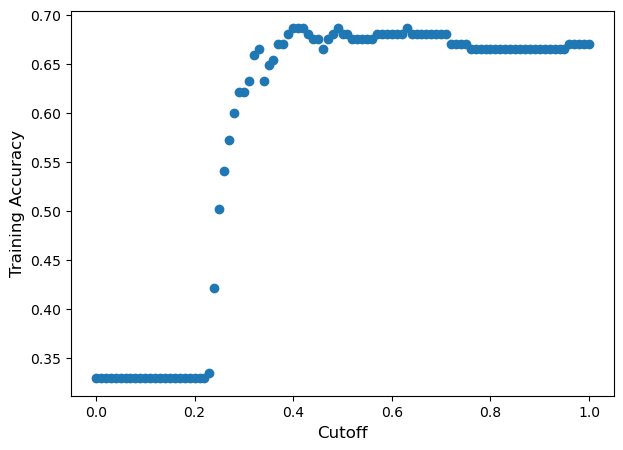

In [89]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()

In [121]:
## demonstrate log_reg.coef_
log_reg.coef_[0][0]

0.013870081860837581

In [91]:
print("A .1 unit increase in our feature multiplies" + 
      " the odds of being classified as 1 by " + 
      str(np.round(np.exp(.1*log_reg.coef_[0][0]),2)))

A .1 unit increase in our feature multiplies the odds of being classified as 1 by 1.0


next steps: 
1. put in data from all but the hold out participants
2. use first predictor project code to get baseline model predictions
3. predict on testing data